In [1]:
import os
import matplotlib as mpl
import matplotlib.pylab as plt
import itertools
import csv , codecs
import glob
from PIL import Image
import numpy as np
import pandas as pd
import openpyxl
from openpyxl import Workbook
from openpyxl import load_workbook
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
def warn(*args, **kwargs): pass
import warnings
warnings.warn = warn
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from tqdm import tqdm

In [2]:
data_dir = "./EEG_data/"

## CSV 파일 생성 함수


### task 0 1 2 : 1-back,  2-back,  rest

### eye 0  1    : close eye,     open eye

### respiratory 0 1 2 : mouse, nose, O2 



In [3]:
def dataset_csv_3():
    normalize_power = str(input("Relative, Abs :"))
    excel_dir = "./EEG_data" + '/' + normalize_power
    excel_list = sorted(glob.glob(excel_dir+'/[!~]*.xlsx'))
    
    subject = int(input("subject :"))
    book = Workbook()
    sheet = book.active
    sheet.cell(row=1, column=161).value = 'target'
 
    # x축 생성   
    for i in range(1,33):
        sheet.cell(row=1, column=i).value = 'ACh' + str(i)
        sheet.cell(row=1, column=i+32).value = 'BCh' + str(i)
        sheet.cell(row=1, column=i+64).value = 'DCh' + str(i)
        sheet.cell(row=1, column=i+96).value = 'GCh' + str(i)
        sheet.cell(row=1, column=i+128).value = 'TCh' + str(i)
        
    # 파일을 순차적으로 열어서 셀 영역을 복사
    for j in range(0,5):
        wb = openpyxl.load_workbook(excel_list[j], data_only=True)
        wb_sheet = wb.sheetnames
        for k in range(0,12):
            source = wb[wb_sheet[k]]
            for l in range(2, 22):
                for m in range(2, 34):
                    sheet.cell(row=20*k+l,column=32*j+m-1).value = source.cell(row=l,column=m).value
        

    with open('./dataset_eeg_3.csv', 'w', newline="") as f:
        c = csv.writer(f)
        for r in sheet.rows:
            c.writerow([cell.value for cell in r])
            
    df = pd.read_csv('./dataset_eeg_3.csv')
    df[df =='                      NaN'] =np.nan
    df = df.fillna(0.0).astype('float64')
    pd.options.mode.chained_assignment = None
#1-back mouse, nose, o2
    df["target"][0*subject:1*subject] = "0" #0:20
    df["target"][1*subject:2*subject] = "1" #21:40
    df["target"][2*subject:3*subject] = "2" #41:60
#2-back mouse, nose, o2
    df["target"][3*subject:4*subject] = "0" #60:80
    df["target"][4*subject:5*subject] = "1" #80:100
    df["target"][5*subject:6*subject] = "2" #100:120
#rest close eye mouse, nose, o2
    df["target"][6*subject:7*subject] = "0" #120:140
    df["target"][7*subject:8*subject] = "1" #140:160
    df["target"][8*subject:9*subject] = "2" #160:180
#rest open eye mouse, nose, o2
    df["target"][9*subject:10*subject] = "0" #180:200
    df["target"][10*subject:11*subject] = "1" #200:220
    df["target"][11*subject:12*subject] = "2" #220:240
    df.astype('float64')
    df.to_csv('./dataset_eeg_3.csv')
    
    return df
            


In [4]:
eeg_data_3 = pd.read_csv('./dataset_eeg_3_O2zero.csv',index_col=0)

In [5]:
idx_ch_list = []
for i in range(0,161):
    idx_ch_list.append(i)
    
for j in range(32*3,32*4):
    idx_ch_list.remove(j)
print(idx_ch_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160]


In [6]:
state={}

state["1back_mouse"]=eeg_data_3.iloc[0:20]
state["1back_nose"]=eeg_data_3.iloc[20:40]
state["1back_O2"]=eeg_data_3.iloc[40:60]

state["2back_mouse"]=eeg_data_3.iloc[60:80]
state["2back_nose"]=eeg_data_3.iloc[80:100]
state["2back_O2"]=eeg_data_3.iloc[100:120]

state["close_rest_mouse"]=eeg_data_3.iloc[120:140]
state["close_rest_nose"]=eeg_data_3.iloc[140:160]
state["close_rest_O2"]=eeg_data_3.iloc[160:180]

state["open_rest_mouse"]=eeg_data_3.iloc[180:200]
state["open_rest_nose"]=eeg_data_3.iloc[200:220]
state["open_rest_O2"]=eeg_data_3.iloc[220:240]

In [7]:
ex_state={}

ex_state["1back_mouse"]=eeg_data_3.iloc[0:20,idx_ch_list]
ex_state["1back_nose"]=eeg_data_3.iloc[20:40,idx_ch_list]
ex_state["1back_O2"]=eeg_data_3.iloc[40:60,idx_ch_list]

ex_state["2back_mouse"]=eeg_data_3.iloc[60:80,idx_ch_list]
ex_state["2back_nose"]=eeg_data_3.iloc[80:100,idx_ch_list]
ex_state["2back_O2"]=eeg_data_3.iloc[100:120,idx_ch_list]

ex_state["close_rest_mouse"]=eeg_data_3.iloc[120:140,idx_ch_list]
ex_state["close_rest_nose"]=eeg_data_3.iloc[140:160,idx_ch_list]
ex_state["close_rest_O2"]=eeg_data_3.iloc[160:180,idx_ch_list]

ex_state["open_rest_mouse"]=eeg_data_3.iloc[180:200,idx_ch_list]
ex_state["open_rest_nose"]=eeg_data_3.iloc[200:220,idx_ch_list]
ex_state["open_rest_O2"]=eeg_data_3.iloc[220:240,idx_ch_list]

In [8]:
ds_train = {}
ds_test = {}


ds_train={"1back_mouse":state["1back_mouse"], 
       "1back_nose":state["1back_nose"],
       "1back_O2":state["1back_O2"],
       "1back_m_n":state["1back_mouse"].append(state["1back_nose"]),
       "1back":state["1back_mouse"].append(state["1back_nose"]).append(state["1back_O2"]),
       
                                               
       "2back_mouse":state["2back_mouse"],
       "2back_nose":state["2back_nose"],
       "2back_O2":state["2back_O2"],
       "2back_m_n":state["2back_mouse"].append(state["2back_nose"]),
       "2back":state["2back_mouse"].append(state["2back_nose"]).append(state["2back_O2"]),
       
       "close_rest_mouse":state["close_rest_mouse"], 
       "close_rest_nose":state["close_rest_nose"],
       "close_rest_O2":state["close_rest_O2"],
       "close_rest_m_n":state["close_rest_mouse"].append(state["close_rest_nose"]),
       "close_rest":state["close_rest_mouse"].append(state["close_rest_nose"]).append(state["close_rest_O2"]),
       
       "open_rest_mouse":state["open_rest_mouse"],
       "open_rest_nose":state["open_rest_nose"],
       "open_rest_O2":state["open_rest_O2"],
       "open_rest_m_n":state["open_rest_mouse"].append(state["open_rest_nose"]),
       "open_rest":state["open_rest_mouse"].append(state["open_rest_nose"]).append(state["open_rest_O2"]),
       
       
       "total_mouse" : state["1back_mouse"].append(state["2back_mouse"]).append(state["close_rest_mouse"]).append(state["open_rest_mouse"]),
       "total_nose" : state["1back_nose"].append(state["2back_nose"]).append(state["close_rest_nose"]).append(state["open_rest_nose"]),
       "total_O2" : state["1back_O2"].append(state["2back_O2"]).append(state["close_rest_O2"]).append(state["open_rest_O2"]),
       "total_m_n": state["1back_mouse"].append(state["1back_nose"]).append(state["2back_mouse"]).append(state["2back_nose"]).append(state["close_rest_mouse"]).append(state["close_rest_nose"]).append(state["open_rest_mouse"]).append(state["open_rest_nose"]),
       "total": state["1back_mouse"].append(state["1back_nose"]).append(state["1back_O2"]).append(state["2back_mouse"]).append(state["2back_nose"]).append(state["2back_O2"]).append(state["close_rest_mouse"]).append(state["close_rest_nose"]).append(state["close_rest_O2"]).append(state["open_rest_mouse"]).append(state["open_rest_nose"]).append(state["open_rest_O2"])
       
       
      }

ds_test = {"1back_mouse":state["1back_mouse"], 
       "1back_nose":state["1back_nose"],
       "1back_O2":state["1back_O2"],
       "1back_m_n":state["1back_mouse"].append(state["1back_nose"]),
       "1back":state["1back_mouse"].append(state["1back_nose"]).append(state["1back_O2"]),
       
                                               
       "2back_mouse":state["2back_mouse"],
       "2back_nose":state["2back_nose"],
       "2back_O2":state["2back_O2"],
       "2back_m_n":state["2back_mouse"].append(state["2back_nose"]),
       "2back":state["2back_mouse"].append(state["2back_nose"]).append(state["2back_O2"]),
       
       "close_rest_mouse":state["close_rest_mouse"], 
       "close_rest_nose":state["close_rest_nose"],
       "close_rest_O2":state["close_rest_O2"],
       "close_rest_m_n":state["close_rest_mouse"].append(state["close_rest_nose"]),
       "close_rest":state["close_rest_mouse"].append(state["close_rest_nose"]).append(state["close_rest_O2"]),
       
       "open_rest_mouse":state["open_rest_mouse"],
       "open_rest_nose":state["open_rest_nose"],
       "open_rest_O2":state["open_rest_O2"],
       "open_rest_m_n":state["open_rest_mouse"].append(state["open_rest_nose"]),
       "open_rest":state["open_rest_mouse"].append(state["open_rest_nose"]).append(state["open_rest_O2"]),
        
        
               
       "total_mouse" : state["1back_mouse"].append(state["2back_mouse"]).append(state["close_rest_mouse"]).append(state["open_rest_mouse"]),
        "total_nose" : state["1back_nose"].append(state["2back_nose"]).append(state["close_rest_nose"]).append(state["open_rest_nose"]),
       "total_O2" : state["1back_O2"].append(state["2back_O2"]).append(state["close_rest_O2"]).append(state["open_rest_O2"]),
       "total_m_n": state["1back_mouse"].append(state["1back_nose"]).append(state["2back_mouse"]).append(state["2back_nose"]).append(state["close_rest_mouse"]).append(state["close_rest_nose"]).append(state["open_rest_mouse"]).append(state["open_rest_nose"]),
        "total": state["1back_mouse"].append(state["1back_nose"]).append(state["1back_O2"]).append(state["2back_mouse"]).append(state["2back_nose"]).append(state["2back_O2"]).append(state["close_rest_mouse"]).append(state["close_rest_nose"]).append(state["close_rest_O2"]).append(state["open_rest_mouse"]).append(state["open_rest_nose"]).append(state["open_rest_O2"])

       }




In [9]:
ex_ds_train = {}
ex_ds_test = {}


ex_ds_train={"1back_mouse":ex_state["1back_mouse"], 
       "1back_nose":ex_state["1back_nose"],
       "1back_O2":ex_state["1back_O2"],
       "1back_m_n":ex_state["1back_mouse"].append(ex_state["1back_nose"]),
       "1back":ex_state["1back_mouse"].append(ex_state["1back_nose"]).append(ex_state["1back_O2"]),
       
                                               
       "2back_mouse":ex_state["2back_mouse"],
       "2back_nose":ex_state["2back_nose"],
       "2back_O2":ex_state["2back_O2"],
       "2back_m_n":ex_state["2back_mouse"].append(ex_state["2back_nose"]),
       "2back":ex_state["2back_mouse"].append(ex_state["2back_nose"]).append(ex_state["2back_O2"]),
       
       "close_rest_mouse":ex_state["close_rest_mouse"], 
       "close_rest_nose":ex_state["close_rest_nose"],
       "close_rest_O2":ex_state["close_rest_O2"],
       "close_rest_m_n":ex_state["close_rest_mouse"].append(ex_state["close_rest_nose"]),
       "close_rest":ex_state["close_rest_mouse"].append(ex_state["close_rest_nose"]).append(ex_state["close_rest_O2"]),
       
       "open_rest_mouse":ex_state["open_rest_mouse"],
       "open_rest_nose":ex_state["open_rest_nose"],
       "open_rest_O2":ex_state["open_rest_O2"],
       "open_rest_m_n":ex_state["open_rest_mouse"].append(ex_state["open_rest_nose"]),
       "open_rest":ex_state["open_rest_mouse"].append(ex_state["open_rest_nose"]).append(ex_state["open_rest_O2"]),
       
       
       "total_mouse" : ex_state["1back_mouse"].append(ex_state["2back_mouse"]).append(ex_state["close_rest_mouse"]).append(ex_state["open_rest_mouse"]),
       "total_nose" : ex_state["1back_nose"].append(ex_state["2back_nose"]).append(ex_state["close_rest_nose"]).append(ex_state["open_rest_nose"]),
       "total_O2" : ex_state["1back_O2"].append(ex_state["2back_O2"]).append(ex_state["close_rest_O2"]).append(ex_state["open_rest_O2"]),
       "total_m_n": ex_state["1back_mouse"].append(ex_state["1back_nose"]).append(ex_state["2back_mouse"]).append(ex_state["2back_nose"]).append(ex_state["close_rest_mouse"]).append(ex_state["close_rest_nose"]).append(ex_state["open_rest_mouse"]).append(ex_state["open_rest_nose"]),
       "total": ex_state["1back_mouse"].append(ex_state["1back_nose"]).append(ex_state["1back_O2"]).append(ex_state["2back_mouse"]).append(ex_state["2back_nose"]).append(ex_state["2back_O2"]).append(ex_state["close_rest_mouse"]).append(ex_state["close_rest_nose"]).append(ex_state["close_rest_O2"]).append(ex_state["open_rest_mouse"]).append(ex_state["open_rest_nose"]).append(ex_state["open_rest_O2"])
       
       
      }

ex_ds_test={"1back_mouse":ex_state["1back_mouse"], 
       "1back_nose":ex_state["1back_nose"],
       "1back_O2":ex_state["1back_O2"],
       "1back_m_n":ex_state["1back_mouse"].append(ex_state["1back_nose"]),
       "1back":ex_state["1back_mouse"].append(ex_state["1back_nose"]).append(ex_state["1back_O2"]),
       
                                               
       "2back_mouse":ex_state["2back_mouse"],
       "2back_nose":ex_state["2back_nose"],
       "2back_O2":ex_state["2back_O2"],
       "2back_m_n":ex_state["2back_mouse"].append(ex_state["2back_nose"]),
       "2back":ex_state["2back_mouse"].append(ex_state["2back_nose"]).append(ex_state["2back_O2"]),
       
       "close_rest_mouse":ex_state["close_rest_mouse"], 
       "close_rest_nose":ex_state["close_rest_nose"],
       "close_rest_O2":ex_state["close_rest_O2"],
       "close_rest_m_n":ex_state["close_rest_mouse"].append(ex_state["close_rest_nose"]),
       "close_rest":ex_state["close_rest_mouse"].append(ex_state["close_rest_nose"]).append(ex_state["close_rest_O2"]),
       
       "open_rest_mouse":ex_state["open_rest_mouse"],
       "open_rest_nose":ex_state["open_rest_nose"],
       "open_rest_O2":ex_state["open_rest_O2"],
       "open_rest_m_n":ex_state["open_rest_mouse"].append(ex_state["open_rest_nose"]),
       "open_rest":ex_state["open_rest_mouse"].append(ex_state["open_rest_nose"]).append(ex_state["open_rest_O2"]),
       
       
       "total_mouse" : ex_state["1back_mouse"].append(ex_state["2back_mouse"]).append(ex_state["close_rest_mouse"]).append(ex_state["open_rest_mouse"]),
       "total_nose" : ex_state["1back_nose"].append(ex_state["2back_nose"]).append(ex_state["close_rest_nose"]).append(ex_state["open_rest_nose"]),
       "total_O2" : ex_state["1back_O2"].append(ex_state["2back_O2"]).append(ex_state["close_rest_O2"]).append(ex_state["open_rest_O2"]),
       "total_m_n": ex_state["1back_mouse"].append(ex_state["1back_nose"]).append(ex_state["2back_mouse"]).append(ex_state["2back_nose"]).append(ex_state["close_rest_mouse"]).append(ex_state["close_rest_nose"]).append(ex_state["open_rest_mouse"]).append(ex_state["open_rest_nose"]),
       "total": ex_state["1back_mouse"].append(ex_state["1back_nose"]).append(ex_state["1back_O2"]).append(ex_state["2back_mouse"]).append(ex_state["2back_nose"]).append(ex_state["2back_O2"]).append(ex_state["close_rest_mouse"]).append(ex_state["close_rest_nose"]).append(ex_state["close_rest_O2"]).append(ex_state["open_rest_mouse"]).append(ex_state["open_rest_nose"]).append(ex_state["open_rest_O2"])
       
       
      }




In [10]:
def LDA_RF_M_N_O2 (tasks, k_parameter, num_iter):
    std = [] 
    cfm = []
#     accuracy_score_list = []
#     sensitivity_score_list = []
#     precision_score_list = []
    
#     for mode in ['no_lda','lda']:
    for mode in ['lda']:
        for task_train,task_test in tasks:

            print('-------------------')
            print('training:{}/test:{}/mode:{}'.format(task_train,task_test,mode))
            train_3 = ds_train[task_train]
            test_3  = ds_test[task_test]

            X = np.array(train_3.iloc[:,0:-1])
            Y = np.array(train_3['target'])

            rnd_clf = RandomForestClassifier(n_estimators=1000, n_jobs=-1)

            all_scores = []
            accuracy_score_list = []
            sensitivity_score_list = []
            precision_score_list = []
            Mouse = 0
            Nose = 0
            for idx in range(num_iter):
                skf = StratifiedKFold(n_splits=k_parameter, shuffle=True)
                skf.get_n_splits(X,Y)

                for train_index, test_index in skf.split(X,Y):

                    X_final = X
                    lda = LinearDiscriminantAnalysis(n_components=1)
                    if(mode == 'lda') : 
                        lda.fit(X,Y)
#                         X_final = X
                        X_final = lda.transform(X)
                    

                    rnd_clf.fit(X_final[train_index], Y[train_index])
                    val_mae = rnd_clf.score(X_final[test_index],Y[test_index])
                    all_scores.append(val_mae)


                    test = np.array(test_3.iloc[:,0:-1])
                    target_a = np.array(test_3['target'])
                    test = lda.transform(test)

                    aaa = rnd_clf.predict(test)
                    bbb = rnd_clf.predict(X_final[train_index])

                    cm = confusion_matrix(Y[train_index],bbb)
                    
                    
                    cfm.append(cm)


                    Mouse = Mouse+np.count_nonzero(aaa==0)
                    Nose = Nose+ np.count_nonzero(aaa==1)
                    std.append(Mouse/(Mouse+Nose))

                    accuracy_score_list.append(accuracy_score(Y[train_index],bbb))
                    sensitivity_score_list.append(recall_score(Y[train_index],bbb))
                    precision_score_list.append(precision_score(Y[train_index],bbb))

#                 Precision_mean.append()

#             print("sensitivity :{}, std : {}".format(np.mean(sensitivity_score_list),np.std(sensitivity_score_list)))
#             print("precision :{}, std : {}".format(np.mean(precision_score_list),np.std(precision_score_list)))
            print('model_score:{}'.format(np.mean(all_scores)))
            print('std:{}'.format(np.std(all_scores)))
            print('mouse:{}({:.4}), nose:{}({:.4}) / total:{}'.format(Mouse,Mouse/(Mouse+Nose),Nose,Nose/(Mouse+Nose),(Mouse+Nose)))

#     return std, cfm, accuracy_score_list, sensitivity_score_list, precision_score_list

In [11]:
def ex_LDA_RF_M_N_O2 (tasks, k_parameter, num_iter):
    std = [] 
    cfm = []

#     for mode in ['no_lda','lda']:
    for mode in ['lda']:
        for task_train,task_test in tasks:

            print('-------------------')
            print('training:{}/test:{}/mode:{}'.format(task_train,task_test,mode))
            train_3 = ex_ds_train[task_train]
            test_3  = ex_ds_test[task_test]

            X = np.array(train_3.iloc[:,0:-1])
            Y = np.array(train_3['target'])

            rnd_clf = RandomForestClassifier(n_estimators=1000, n_jobs=-1)

            all_scores = []
            Mouse = 0
            Nose = 0
            for idx in range(num_iter):
                skf = StratifiedKFold(n_splits=k_parameter, shuffle=True)
#                 print(skf.get_n_splits(X,Y))

                for train_index, test_index in skf.split(X,Y):

                    X_final = X
                    lda = LinearDiscriminantAnalysis(n_components=1)
                    if(mode == 'lda') : 
                        lda.fit(X,Y)
#                         X_final = X
                        X_final = lda.transform(X)
                    

                    rnd_clf.fit(X_final[train_index], Y[train_index])
                    val_mae = rnd_clf.score(X_final[test_index],Y[test_index])
                    all_scores.append(val_mae)

                    test = np.array(test_3.iloc[:,0:-1])
                    target_a = np.array(test_3['target'])

                    if mode == 'lda':
#                         pass
                        test = lda.transform(test)

                    aaa = rnd_clf.predict(test)
                    bbb = rnd_clf.predict(X_final[train_index])

                    cm = confusion_matrix(Y[train_index],bbb)
                    cfm.append(cm)

                    Mouse = Mouse+np.count_nonzero(aaa==0)
                    Nose = Nose+ np.count_nonzero(aaa==1)
                    std.append(Mouse/(Mouse+Nose))


            print('model_score:{}'.format(np.mean(all_scores)))
            print('std:{}'.format(np.std(all_scores)))
            print('mouse:{}({:.4}), nose:{}({:.4}) / total:{}'.format(Mouse,Mouse/(Mouse+Nose),Nose,Nose/(Mouse+Nose),(Mouse+Nose)))
            
    return std, cfm

# Task list

        * 1back_mouse, 1back_nose, 1back_O2, 1back_m_n, 1back
        
        
        * 2back_mouse, 2back_nose, 2back_O2, 2back_m_n, 2back
        
        
        * close_rest_mouse, close_rest_nose, close_rest_O2, close_rest_m_n, close_rest
        
        
        * open_rest_mouse, open_rest_nose, open_rest_O2, open_rest_m_n, open_rest
        
        * total_mouse, total_nose, total_O2, total_m_n
 


### Poster Result data

# 기존 결과

In [ ]:
print(" Result data")
tasks1 = [
    ('close_rest_m_n','close_rest_O2'),
    ('close_rest_m_n','open_rest_O2'),
     ('close_rest_m_n','1back_O2'),
     ('close_rest_m_n','2back_O2'),

 ]
print("LDA-RF")
result = LDA_RF_M_N_O2(tasks1,k_parameter = 10,num_iter = 50)


 Result data
LDA-RF
-------------------
training:close_rest_m_n/test:close_rest_O2/mode:lda


# Exclusive Gamma band Result


In [ ]:
print(" Result data")
tasks1 = [
    ('close_rest_m_n','close_rest_O2'),
    ('close_rest_m_n','open_rest_O2'),
     ('close_rest_m_n','1back_O2'),
     ('close_rest_m_n','2back_O2'),

 ]
print("LDA-RF")
ex_result = ex_LDA_RF_M_N_O2(tasks1,k_parameter = 10,num_iter = 50)


### **Table 1.** 
Results of 50 iterations of 10-fold cross-validation. Inference performance by the linear discriminant analysis random forest (LDARF) classifier with test data subsets (closed eye rest during mouth and nose breathing) in each cross-validation is presented using accuracy, precision, and sensitivity.

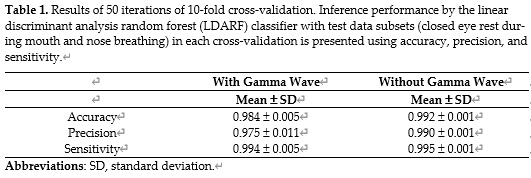

In [ ]:

train_3 = ds_train['close_rest_m_n']
test_3 = ds_train['close_rest_mouse']
test_4 = ds_train['close_rest_nose']

X = np.array(train_3.iloc[:,0:-1])
Y = np.array(train_3['target'])


rnd_clf = RandomForestClassifier(n_estimators=1000, n_jobs=-1)

#                    
accuracy = []
precision = []
sensitivity = []


# Mouse_Mouse = 0
# Mouse_Nose=0
# Nose_Mouse =0
# Nose_Nose = 0
for idx in tqdm(range(50)):
    skf = StratifiedKFold(n_splits=10, shuffle=True)
    skf.get_n_splits(X,Y)
    Mouse_Mouse = 0
    Mouse_Nose=0
    Nose_Mouse =0
    Nose_Nose = 0
    for train_index, test_index in skf.split(X,Y):
        X_final = X
        lda = LinearDiscriminantAnalysis(n_components=1)
        lda.fit(X,Y)
        X_final = lda.transform(X)
        rnd_clf.fit(X_final[train_index], Y[train_index])
        val_mae = rnd_clf.score(X_final[test_index],Y[test_index])
        
        test_m = np.array(test_3.iloc[:,0:-1])
        test_m = lda.transform(test_m)
        predict_m = rnd_clf.predict(test_m)
        
        Mouse_Mouse = Mouse_Mouse+np.count_nonzero(predict_m==0)
        Mouse_Nose = Mouse_Nose+ np.count_nonzero(predict_m==1)

        
    for train_index, test_index in skf.split(X,Y):
        X_final = X
        lda = LinearDiscriminantAnalysis(n_components=1)
        lda.fit(X,Y)
        X_final = lda.transform(X)
        rnd_clf.fit(X_final[train_index], Y[train_index])
        val_mae = rnd_clf.score(X_final[test_index],Y[test_index])
        
        test_n = np.array(test_4.iloc[:,0:-1])
        test_n = lda.transform(test_n)
        predict_n = rnd_clf.predict(test_n)
        
        Nose_Mouse = Nose_Mouse+np.count_nonzero(predict_n==0)
        Nose_Nose = Nose_Nose+ np.count_nonzero(predict_n==1)
#     print(Mouse_Mouse)
#     print(Mouse_Nose)
#     print(Nose_Mouse)
#     print(Nose_Nose)
    accuracy.append((Mouse_Mouse+Nose_Nose)/(Mouse_Mouse+Mouse_Nose+Nose_Mouse+Nose_Nose))
    precision.append(Mouse_Mouse/(Mouse_Mouse+Nose_Mouse))
    sensitivity.append(Mouse_Mouse/(Mouse_Mouse+Mouse_Nose))                           

# print(accuracy)
# print(precision)
# print(sensitivity)
print("With Gamma Wave")
print("Accuracy mean :{}, std : {}".format(np.round(np.mean(accuracy),5),np.round(np.std(accuracy),5)))
print("Precision mean :{}, std : {}".format(np.round(np.mean(precision),5),np.round(np.std(precision),5)))
print("Sensitivity mean :{}, std : {}".format(np.round(np.mean(sensitivity),5),np.round(np.std(sensitivity),5)))



In [ ]:

train_3 = ex_ds_train['close_rest_m_n']
test_3 = ex_ds_train['close_rest_mouse']
test_4 = ex_ds_train['close_rest_nose']

X = np.array(train_3.iloc[:,0:-1])
Y = np.array(train_3['target'])


rnd_clf = RandomForestClassifier(n_estimators=1000, n_jobs=-1)

#                    
ex_accuracy = []
ex_precision = []
ex_sensitivity = []


# Mouse_Mouse = 0
# Mouse_Nose=0
# Nose_Mouse =0
# Nose_Nose = 0
for idx in tqdm(range(50)):
    skf = StratifiedKFold(n_splits=10, shuffle=True)
    skf.get_n_splits(X,Y)
    Mouse_Mouse = 0
    Mouse_Nose=0
    Nose_Mouse =0
    Nose_Nose = 0
    for train_index, test_index in skf.split(X,Y):
        X_final = X
        lda = LinearDiscriminantAnalysis(n_components=1)
        lda.fit(X,Y)
        X_final = lda.transform(X)
        rnd_clf.fit(X_final[train_index], Y[train_index])
        val_mae = rnd_clf.score(X_final[test_index],Y[test_index])
        
        test_m = np.array(test_3.iloc[:,0:-1])
        test_m = lda.transform(test_m)
        predict_m = rnd_clf.predict(test_m)
        
        Mouse_Mouse = Mouse_Mouse+np.count_nonzero(predict_m==0)
        Mouse_Nose = Mouse_Nose+ np.count_nonzero(predict_m==1)

        
    for train_index, test_index in skf.split(X,Y):
        X_final = X
        lda = LinearDiscriminantAnalysis(n_components=1)
        lda.fit(X,Y)
        X_final = lda.transform(X)
        rnd_clf.fit(X_final[train_index], Y[train_index])
        val_mae = rnd_clf.score(X_final[test_index],Y[test_index])
        
        test_n = np.array(test_4.iloc[:,0:-1])
        test_n = lda.transform(test_n)
        predict_n = rnd_clf.predict(test_n)
        
        Nose_Mouse = Nose_Mouse+np.count_nonzero(predict_n==0)
        Nose_Nose = Nose_Nose+ np.count_nonzero(predict_n==1)
#     print(Mouse_Mouse)
#     print(Mouse_Nose)
#     print(Nose_Mouse)
#     print(Nose_Nose)
    ex_accuracy.append((Mouse_Mouse+Nose_Nose)/(Mouse_Mouse+Mouse_Nose+Nose_Mouse+Nose_Nose))
    ex_precision.append(Mouse_Mouse/(Mouse_Mouse+Nose_Mouse))
    ex_sensitivity.append(Mouse_Mouse/(Mouse_Mouse+Mouse_Nose))                           

# print(accuracy)
# print(precision)
# print(sensitivity)
print("Without Gamma Wave")
print("Accuracy mean :{}, std : {}".format(np.round(np.mean(ex_accuracy),5),np.round(np.std(ex_accuracy),5)))
print("Precision mean :{}, std : {}".format(np.round(np.mean(ex_precision),5),np.round(np.std(ex_precision),5)))
print("Sensitivity mean :{}, std : {}".format(np.round(np.mean(ex_sensitivity),5),np.round(np.std(ex_sensitivity),5)))




## Table 3

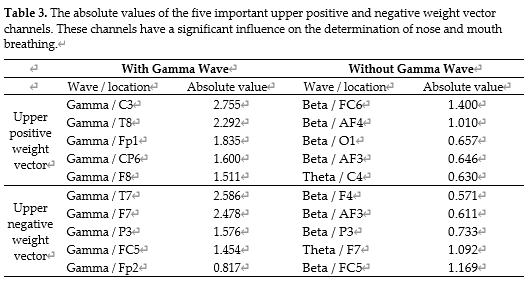

### LDA_Co_efficient 뽑아낸것

In [ ]:
m_n = ds_train['close_rest_m_n']
m_n_X = np.array(m_n.iloc[:,0:-1])
m_n_Y = np.array(m_n['target'])
lda = LinearDiscriminantAnalysis(n_components=1)
lda.fit(m_n_X,m_n_Y)

channel_info = []

for channel, coef in zip(eeg_data_3.columns[:-1], lda.coef_[0]):
    channel_info.append([channel, coef])
    


In [ ]:
alpha = pd.DataFrame(channel_info[0:32],columns=['channel','LDARF_Coefficient'])
beta = pd.DataFrame(channel_info[32:64],columns=['channel','LDARF_Coefficient'])
delta = pd.DataFrame(channel_info[64:96],columns=['channel','LDARF_Coefficient'])
gamma = pd.DataFrame(channel_info[96:128],columns=['channel','LDARF_Coefficient'])
theta = pd.DataFrame(channel_info[128:160],columns=['channel','LDARF_Coefficient'])

alpha.to_csv('./Result/alpha.csv')
beta.to_csv('./Result/beta.csv')
delta.to_csv('./Result/delta.csv')
gamma.to_csv('./Result/gamma.csv')
theta.to_csv('./Result/theta.csv')


### LDA_Co_efficient 뽑아낸것( exclusive gamma)

In [ ]:
m_n = ex_ds_train['close_rest_m_n']
m_n_X = np.array(m_n.iloc[:,0:-1])
m_n_Y = np.array(m_n['target'])
lda = LinearDiscriminantAnalysis(n_components=1)
lda.fit(m_n_X,m_n_Y)

ex_channel_info= []

for channel, coef in zip(m_n.columns[:-1], lda.coef_[0]):
    ex_channel_info.append([channel, coef])
    

In [ ]:
ex_alpha = pd.DataFrame(ex_channel_info[0:32],columns=['channel','LDARF_Coefficient'])
ex_beta = pd.DataFrame(ex_channel_info[32:64],columns=['channel','LDARF_Coefficient'])
ex_delta = pd.DataFrame(ex_channel_info[64:96],columns=['channel','LDARF_Coefficient'])
ex_theta = pd.DataFrame(ex_channel_info[96:128],columns=['channel','LDARF_Coefficient'])

ex_alpha.to_csv('./Result/ex_alpha.csv')
ex_beta.to_csv('./Result/ex_beta.csv')
ex_delta.to_csv('./Result/ex_delta.csv')
ex_theta.to_csv('./Result/ex_theta.csv')


In [ ]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(3,2,1)
ax2 = fig.add_subplot(3,2,2)
ax3= fig.add_subplot(3,2,3)
ax4= fig.add_subplot(3,2,4)
ax5=fig.add_subplot(3,2,5)

ax1.bar(np.arange(1,33,1),alpha["LDARF_Coefficient"])
ax1.set_yticks([-3,-2,-1,0,1,2,3])
ax1.set_ylabel("LDA transformed coef")
ax1.set_xlabel("Channel")
ax1.set_title("Alpha")
ax1.grid()

ax2.bar(np.arange(1,33,1),beta["LDARF_Coefficient"])
ax2.set_yticks([-3,-2,-1,0,1,2,3])
ax2.set_ylabel("LDA transformed coef")
ax2.set_xlabel("Channel")
ax2.set_title("Beta")
ax2.grid()


ax3.bar(np.arange(1,33,1),delta["LDARF_Coefficient"])
ax3.set_yticks([-3,-2,-1,0,1,2,3])
ax3.set_ylabel("LDA transformed coef")
ax3.set_xlabel("Channel")
ax3.set_title("Delta")
ax3.grid()


ax4.bar(np.arange(1,33,1),gamma["LDARF_Coefficient"])
ax4.set_yticks([-3,-2,-1,0,1,2,3])
ax4.set_ylabel("LDA transformed coef")
ax4.set_xlabel("Channel")
ax4.set_title("Gamma")
ax4.grid()


ax5.bar(np.arange(1,33,1),theta["LDARF_Coefficient"])
ax5.set_yticks([-3,-2,-1,0,1,2,3])
ax5.set_ylabel("LDA transformed coef")
ax5.set_xlabel("Channel")
ax5.set_title("Theta")
ax5.grid()
fig.tight_layout()


In [ ]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3= fig.add_subplot(2,2,3)
ax4= fig.add_subplot(2,2,4)

ax1.bar(np.arange(1,33,1),ex_alpha["LDARF_Coefficient"])
ax1.set_yticks([-3,-2,-1,0,1,2,3])
ax1.set_ylabel("LDA transformed coef")
ax1.set_xlabel("Channel")
ax1.set_title("Alpha")
ax1.grid()

ax2.bar(np.arange(1,33,1),ex_beta["LDARF_Coefficient"])
ax2.set_yticks([-3,-2,-1,0,1,2,3])
ax2.set_ylabel("LDA transformed coef")
ax2.set_xlabel("Channel")
ax2.set_title("Beta")
ax2.grid()


ax3.bar(np.arange(1,33,1),ex_delta["LDARF_Coefficient"])
ax3.set_yticks([-3,-2,-1,0,1,2,3])
ax3.set_ylabel("LDA transformed coef")
ax3.set_xlabel("Channel")
ax3.set_title("Delta")
ax3.grid()



ax4.bar(np.arange(1,33,1),ex_theta["LDARF_Coefficient"])
ax4.set_yticks([-3,-2,-1,0,1,2,3])
ax4.set_ylabel("LDA transformed coef")
ax4.set_xlabel("Channel")
ax4.set_title("Theta")
ax4.grid()
fig.tight_layout()


In [ ]:
ex_dict ={'alpha':np.sum(abs(ex_alpha['LDARF_Coefficient'])),
          'beta':np.sum(abs(ex_beta['LDARF_Coefficient'])),
          'delta':np.sum(abs(ex_delta['LDARF_Coefficient'])),
          'theta':np.sum(abs(ex_theta['LDARF_Coefficient']))}

In [ ]:
dict_ ={'alpha':np.sum(abs(alpha['LDARF_Coefficient'])),
        'beta':np.sum(abs(beta['LDARF_Coefficient'])),
        'delta':np.sum(abs(delta['LDARF_Coefficient'])),
        'theta':np.sum(abs(theta['LDARF_Coefficient'])),
        'gamma':np.sum(abs(gamma['LDARF_Coefficient']))}

# LDA coefficient 결과 

In [ ]:
pd.Series(dict_).sort_values(axis=0,ascending=False)

# Gamma exclusive LDA coeffienct 결과

In [ ]:
pd.Series(ex_dict).sort_values(axis=0,ascending=False)

# 

In [ ]:
total = pd.DataFrame(channel_info,columns=['channel','LDARF_Coefficient'])
sorted_total = total.sort_values('LDARF_Coefficient',ascending=False)
sorted_total.to_csv('./Result/LDA_coefficient_including_gamma.csv')

In [ ]:
ex_total = pd.DataFrame(ex_channel_info,columns=['channel','LDARF_Coefficient'])
sorted_total_ex_total = ex_total.sort_values('LDARF_Coefficient',ascending=False)
sorted_total_ex_total.to_csv('./Result/LDA_coefficient_excluding_gamma.csv')

In [ ]:
including_gamma_total = []
for i in range(len(channel_info[0:32*3])):
    including_gamma_total.append(channel_info[i])
for j in range(0,32,1):
    including_gamma_total.append(channel_info[32*4+j])


In [ ]:
a_total = pd.DataFrame(including_gamma_total,columns=['channel','LDARF_Coefficient'])
include_sorted_total = a_total.sort_values('LDARF_Coefficient',ascending=False)
include_sorted_total.to_csv('./Result/LDA_coefficient_including_gamma(except_gamma).csv')

In [ ]:
sorted_total['rank'] = sorted_total['LDARF_Coefficient'].rank(ascending=False)
sorted_total

In [ ]:
sorted_total_ex_total['rank'] = sorted_total_ex_total['LDARF_Coefficient'].rank(ascending=False)
sorted_total_ex_total

In [ ]:
a = []
sort_a = alpha.sort_values('LDARF_Coefficient',ascending=False)
for i,j in zip( sort_a['channel'], sort_a['LDARF_Coefficient']):
    a.append('{}({})'.format(i,np.round(j,3)))
    
b = []
sort_b = beta.sort_values('LDARF_Coefficient',ascending=False)
for i,j in zip( sort_b['channel'], sort_b['LDARF_Coefficient']):
    b.append('{}({})'.format(i,np.round(j,3)))
    

d = []
sort_d = delta.sort_values('LDARF_Coefficient',ascending=False)
for i,j in zip( sort_d['channel'], sort_d['LDARF_Coefficient']):
    d.append('{}({})'.format(i,np.round(j,3))) 

g = []
sort_g = gamma.sort_values('LDARF_Coefficient',ascending=False)
for i,j in zip( sort_g['channel'], sort_g['LDARF_Coefficient']):
    g.append('{}({})'.format(i,np.round(j,3))) 
    
t = [] 
sort_t = theta.sort_values('LDARF_Coefficient',ascending=False)
for i,j in zip( sort_t['channel'], sort_t['LDARF_Coefficient']):
    t.append('{}({})'.format(i,np.round(j,3))) 

In [ ]:
result_sort_channel = pd.DataFrame({'alpha':a,
                                    'beta':b,
                                    'gamma':g,
                                    'delta':d,
                                    'theta':d})
result_sort_channel.to_csv('./Result/sorted_channel_subband_including_gamma.csv')
result_sort_channel

In [ ]:
ex_a = []
ex_sort_a = ex_alpha.sort_values('LDARF_Coefficient',ascending=False)
for i,j in zip( ex_sort_a['channel'], ex_sort_a['LDARF_Coefficient']):
    ex_a.append('{}({})'.format(i,np.round(j,3)))
    
ex_b = []
ex_sort_b = ex_beta.sort_values('LDARF_Coefficient',ascending=False)
for i,j in zip( ex_sort_b['channel'], ex_sort_b['LDARF_Coefficient']):
    ex_b.append('{}({})'.format(i,np.round(j,3)))
    

ex_d = []
ex_sort_d = ex_delta.sort_values('LDARF_Coefficient',ascending=False)
for i,j in zip( ex_sort_d['channel'], ex_sort_d['LDARF_Coefficient']):
    ex_d.append('{}({})'.format(i,np.round(j,3))) 

    
ex_t = [] 
ex_sort_t = ex_theta.sort_values('LDARF_Coefficient',ascending=False)
for i,j in zip( ex_sort_t['channel'], ex_sort_t['LDARF_Coefficient']):
    ex_t.append('{}({})'.format(i,np.round(j,3))) 

In [ ]:
ex_result_sort_channel = pd.DataFrame({'alpha':ex_a,
                                    'beta':ex_b,
                                    'delta':ex_d,
                                    'theta':ex_d})
ex_result_sort_channel.to_csv('./Result/sorted_channel_subband_excluding_gamma.csv')
ex_result_sort_channel